In [12]:
# all imports
import numpy as np
import os
import requests
from astropy.table import Table, vstack
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
import math
import matplotlib as mpl
from astropy.visualization.wcsaxes import SphericalCircle
import pandas as pd
import random
from matplotlib.patches import Ellipse

In [3]:
# define directories
data_dir = '/global/cfs/projectdirs/desi/science/td/pv/tfgalaxies/'
cache_dir = '/pscratch/sd/j/jjpim/cache/' # my cache path
vi_dir = '/pscratch/sd/j/jjpim/visual_inspection/' # vi image path
v_dir = '/pscratch/sd/j/jjpim/2Dvmap/' # 2D velocity map image path

In [9]:
# load updated fuji table
tf_fuji = Table.read(data_dir + 'SV/desi_pv_tf_fuji_healpix_rotcurve_EOA_VI_velocity.fits') 
# load iron table
tf_iron = Table.read(data_dir + 'Y1/desi_pv_tf_iron_healpix_rotcurve_EOA_VI_velocity.fits')
#combine
tf_mastertable = vstack([tf_fuji,tf_iron])
#unique SGA IDs
tf_galaxies = np.unique(tf_mastertable['SGA_ID'])
#dictionary
tf_mastertable_dict = {}
for sga_id in np.unique(tf_mastertable['SGA_ID']):
    tf_mastertable_dict[sga_id] = np.where(tf_mastertable['SGA_ID'] == sga_id)[0]
tf_mastertable[:5]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC,OBS_IN_SV,SKY_FIBER_DIST,SKY_FIBER_DIST_R26,ROT_CURVE,EOA,VELOCITY,VERR
int64,float64,float64,int64,bytes4,float64,float64,int64,float64,bytes65,bytes3,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1079550234591232,194.390863195343,27.5157211790145,10378,sv3,1.1235686466514,7.31685779475115e-05,4,3.28414569795132,fuji/healpix/sv3/bright/103/10378/redrock-sv3-bright-10378.fits,EXT,662902,194.39086319534337,27.51572117901454,1.0,0.03927420444753712,1.0000000170652443,0.0,0.0,--,inf
1092744374124544,194.390863195343,27.5157211790145,10378,sv3,0.686773088332363,6.9756676262104e-05,4,0.786607094109058,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.39086319534337,27.51572117901454,1.0,0.03927420444753712,1.0000000170652443,0.0,0.0,--,inf
1092744374124546,194.364461113654,27.5037185881314,10378,sv3,0.0242933923052181,4.95233472646785e-05,0,95.428411073226,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.36446111365385,27.50371858813136,1.0,0.012960487467698754,0.3300000056318236,0.0,0.0,--,inf
1092744369930240,194.338458724402,27.4918902690326,10378,sv3,0.0264170223697961,0.00010139452689994,0,9.53278421035066,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.33845872440244,27.491890269032595,1.0,0.012960487467685656,0.33000000563149007,0.0,0.0,--,inf
1092744374124545,194.377858465028,27.5098100780282,10378,sv3,0.211332646769145,6.68535116703737e-05,4,3.73989077657461,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.3778584650283,27.509810078028195,1.0,0.026313716979861984,0.6700000114340222,0.0,0.0,--,inf


In [5]:
# load SGA table
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')
SGA_dict = {}
for i in range(len(SGA)):
    SGA_dict[SGA['SGA_ID'][i]] = i
SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0.4017908,

In [6]:
#find sga id with the most targets
for sga_id in tf_galaxies:
    if len(tf_mastertable[tf_mastertable['SGA_ID']==  sga_id])>25:
        print(sga_id)

547778
608015
1065602
1333993


In [8]:
tf_mastertable[tf_mastertable['SGA_ID']==  547778]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC,OBS_IN_SV,SKY_FIBER_DIST,SKY_FIBER_DIST_R26,ROT_CURVE,EOA,VELOCITY,VERR
int64,float64,float64,int64,bytes4,float64,float64,int64,float64,bytes65,bytes3,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1070241199161348,208.737562035713,5.31217069943004,26432,sv3,0.976094192762309,9.45906373675737e-05,4,3.21022426424406,fuji/healpix/sv3/bright/264/26432/redrock-sv3-bright-26432.fits,EXT,547778,208.7375620357128,5.31217069943004,1.0,0.02245240582779445,0.33000001952950575,1.0,0.0,291238.80353103776,28.37155491480249
1083435338694660,208.737562035713,5.31217069943004,26432,sv3,0.00435515438171736,5.95161028988655e-05,0,64.5522083645719,fuji/healpix/sv3/dark/264/26432/redrock-sv3-dark-26432.fits,EXT,547778,208.7375620357128,5.31217069943004,1.0,0.02245240582779445,0.33000001952950575,1.0,0.0,-81.23131963612231,17.864713438306783
1070241199161347,208.731457742922,5.2898507250167,26090,sv3,1.57006508717067,0.000322143854789214,4,5.79736968129873,fuji/healpix/sv3/bright/260/26090/redrock-sv3-bright-26090.fits,EXT,547778,208.73145774292163,5.289850725016704,1.0,0.045585187589727544,0.6700000396502718,1.0,0.0,469306.79794617876,96.58040838406671
1083435338694659,208.731457742922,5.2898507250167,26090,sv3,1.42390790193348,0.000100214069953148,0,10.5246824920177,fuji/healpix/sv3/dark/260/26090/redrock-sv3-dark-26090.fits,EXT,547778,208.73145774292163,5.289850725016704,1.0,0.045585187589727544,0.6700000396502718,1.0,0.0,425489.9761295602,30.05663261601853
1070241199161349,208.749412809371,5.35549753719813,26432,sv3,1.52905722130535,0.000140484931635865,4,3.14328634738922,fuji/healpix/sv3/bright/264/26432/redrock-sv3-bright-26432.fits,EXT,547778,208.7494128093705,5.355497537198131,1.0,0.02245240582783662,0.3300000195301256,1.0,0.0,457012.94904108014,42.125747441844965
1083435338694661,208.749412809371,5.35549753719813,26432,sv3,0.00507397495818972,5.23344718138087e-05,0,110.570778177287,fuji/healpix/sv3/dark/264/26432/redrock-sv3-dark-26432.fits,EXT,547778,208.7494128093705,5.355497537198131,1.0,0.02245240582783662,0.3300000195301256,1.0,0.0,134.26566784550334,15.714761154874777
1070247217987594,208.755518408261,5.37781733453269,26432,sv3,0.528451150168133,0.000106005130313453,4,1.68334472924471,fuji/healpix/sv3/bright/264/26432/redrock-sv3-bright-26432.fits,EXT,547778,208.75551840826128,5.377817334532686,1.0,0.04558518758988767,0.6700000396526252,1.0,0.0,157038.79548513106,31.79202745110391
1083441357520906,208.755518408261,5.37781733453269,26432,sv3,0.000114926282582196,5.57883704550061e-05,0,62.9426100458277,fuji/healpix/sv3/dark/264/26432/redrock-sv3-dark-26432.fits,EXT,547778,208.75551840826128,5.377817334532686,1.0,0.04558518758988767,0.6700000396526252,1.0,0.0,-1352.4197239565208,16.748651029397664
1070241199161346,208.725533409266,5.26818716334567,26090,sv3,1.50434103468737,0.00019739069465876,4,2.14405116438866,fuji/healpix/sv3/bright/260/26090/redrock-sv3-bright-26090.fits,TFT,547778,208.72553340926592,5.268187163345671,1.0,0.06803759341745368,1.0000000591787734,1.0,0.0,449603.22270248923,59.18294940132451


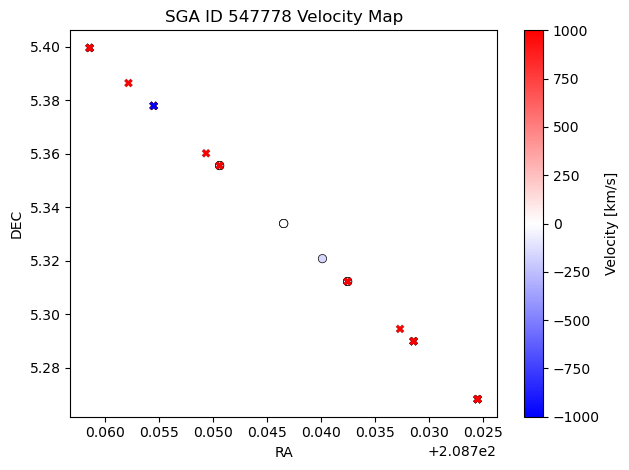

In [7]:
#plotting without ellipse
plt.figure(tight_layout=True)
#define plotting variables
galaxy = tf_mastertable[tf_mastertable['SGA_ID'] == 547778]
x = galaxy['RA']
y = galaxy['DEC']
c = galaxy['VELOCITY']

# find max of absolute value of the leftover velocities
velocity_abs = np.abs(c)
v_max = np.max(velocity_abs)

#define colorbar
if v_max > 1000:
    vmin = -1000
    vmax = 1000
else:
    vmin = -v_max
    vmax = +v_max
    
# separate the data into velocity types
high_velocity = galaxy[np.abs(c) > 1000]
low_velocity = galaxy[np.abs(c) <= 1000]

plt.scatter(low_velocity['RA'], low_velocity['DEC'], c=low_velocity['VELOCITY'], marker='o', cmap='bwr', linewidths=0.5, edgecolors='black', vmin=vmin, vmax=vmax)
plt.scatter(high_velocity['RA'], high_velocity['DEC'], c=high_velocity['VELOCITY'], marker='X', cmap='bwr', linewidths=0.1, edgecolors='black', vmin=vmin, vmax=vmax)

# plot!!!
plt.colorbar(label='Velocity [km/s]')
plt.gca().invert_xaxis()
plt.xlabel('RA')
plt.ylabel('DEC')
plt.title('SGA ID {} Velocity Map'.format(galaxy['SGA_ID'][0]));          

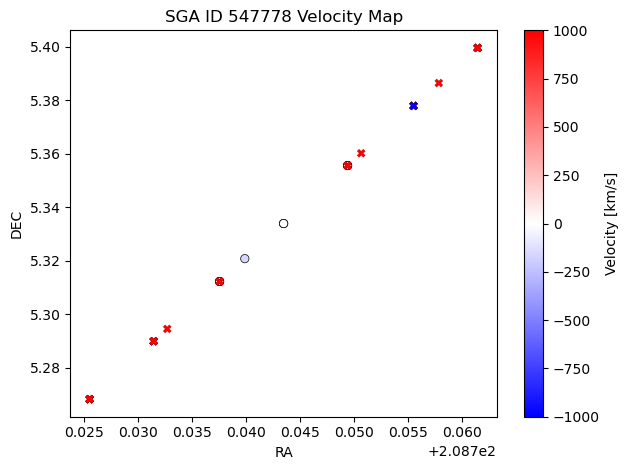

In [22]:
#attempt at plotting with ellipse 

plt.figure(tight_layout=True)
#define plotting variables
galaxy = tf_mastertable[tf_mastertable['SGA_ID'] == 547778]
x = galaxy['RA']
y = galaxy['DEC']
c = galaxy['VELOCITY']
sga_galaxy = SGA[SGA['SGA_ID'] == 547778]
major = sga_galaxy['D26']
ratio = sga_galaxy['BA']
minor = major*ratio
theta = sga_galaxy['PA']

# find max of absolute value of the leftover velocities
velocity_abs = np.abs(c)
v_max = np.max(velocity_abs)

#define colorbar
if v_max > 1000:
    vmin = -1000
    vmax = 1000
else:
    vmin = -v_max
    vmax = +v_max
    
# separate the data into velocity types
high_velocity = galaxy[np.abs(c) > 1000]
low_velocity = galaxy[np.abs(c) <= 1000]

# generate ellipses
ell = Ellipse(
        xy=[x, y],
        width= [minor],
        height=[major],
        angle=np.radians(theta) 
        )
#plt.gca().add_patch(ell)

plt.scatter(low_velocity['RA'], low_velocity['DEC'], c=low_velocity['VELOCITY'], marker='o', cmap='bwr', linewidths=0.5, edgecolors='black', vmin=vmin, vmax=vmax)
plt.scatter(high_velocity['RA'], high_velocity['DEC'], c=high_velocity['VELOCITY'], marker='X', cmap='bwr', linewidths=0.1, edgecolors='black', vmin=vmin, vmax=vmax)

# plot!!!
plt.colorbar(label='Velocity [km/s]')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.title('SGA ID {} Velocity Map'.format(galaxy['SGA_ID'][0]))
 
#
'''
# either load an existing image or save fig to scratch
img_name = v_dir + '{}.jpg'.format(sga_id)
if os.path.exists(img_name):
    if verbose:
        print('{} exists.'.format(img_name))
else:
    plt.savefig(v_dir + '{}.png'.format(sga_id), dpi=120)
''';

In [ ]:
# code for displaying multiple images in one figure - NEED TO MODIFY
# create figure 
fig = plt.figure(figsize=(10, 7)) 

# setting values to rows and column variables 
rows = 2
columns = 2

# reading images 
Image1 = cv2.imread('Image1.jpg') 
Image2 = cv2.imread('Image2.jpg') 
Image3 = cv2.imread('Image3.jpg') 
Image4 = cv2.imread('Image4.jpg') 

# Adds a subplot at the 1st position 
fig.add_subplot(rows, columns, 1) 

# showing image 
plt.imshow(Image1) 
plt.axis('off') 
plt.title("First") 

# Adds a subplot at the 2nd position 
fig.add_subplot(rows, columns, 2) 

# showing image 
plt.imshow(Image2) 
plt.axis('off') 
plt.title("Second") 

# Adds a subplot at the 3rd position 
fig.add_subplot(rows, columns, 3) 

# showing image 
plt.imshow(Image3) 
plt.axis('off') 
plt.title("Third") 

# Adds a subplot at the 4th position 
fig.add_subplot(rows, columns, 4) 

# showing image 
plt.imshow(Image4) 
plt.axis('off') 
plt.title("Fourth") 


In [ ]:
#combining figures 

In [141]:
print(velocity_abs)

     VELOCITY     
------------------
 81.23131963612231
134.26566784550334
1352.4197239565208
 81.23131963612231
0.8195361185068979
134.26566784550334
1352.4197239565208
 156.8537839869129
 2.003661701254118
  1.18412558274696


In [84]:
celsius = int(input('Enter the temperature in Celsius: '))
fahrenheit = (9/5)*celsius + 32
print (f'The temperature in Fahrenheit is: \t {fahrenheit:.2f}')

Enter the temperature in Celsius:  23


The temperature in Fahrenheit is: 	 73.40
